In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline

In [2]:
df = pd.read_csv('data/DataScience_salaries_2024.csv')
df

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2021,MI,FT,Data Scientist,30400000,CLP,40038,CL,100,CL,L
1,2021,MI,FT,BI Data Analyst,11000000,HUF,36259,HU,50,US,L
2,2020,MI,FT,Data Scientist,11000000,HUF,35735,HU,50,HU,L
3,2021,MI,FT,ML Engineer,8500000,JPY,77364,JP,50,JP,S
4,2022,SE,FT,Lead Machine Learning Engineer,7500000,INR,95386,IN,50,IN,L
...,...,...,...,...,...,...,...,...,...,...,...
14833,2022,MI,FT,Business Intelligence Developer,15000,USD,15000,GH,100,GH,M
14834,2020,EX,FT,Staff Data Analyst,15000,USD,15000,NG,0,CA,M
14835,2021,EN,FT,Machine Learning Developer,15000,USD,15000,TH,100,TH,L
14836,2022,EN,FT,Data Analyst,15000,USD,15000,ID,0,ID,L


In [3]:
# Make all string columns lowercase and replace spaces with underscores
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].str.lower().str.replace(' ', '_')

In [4]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2021,mi,ft,data_scientist,30400000,clp,40038,cl,100,cl,l
1,2021,mi,ft,bi_data_analyst,11000000,huf,36259,hu,50,us,l
2,2020,mi,ft,data_scientist,11000000,huf,35735,hu,50,hu,l
3,2021,mi,ft,ml_engineer,8500000,jpy,77364,jp,50,jp,s
4,2022,se,ft,lead_machine_learning_engineer,7500000,inr,95386,in,50,in,l


In [5]:
for feature in df.columns:
    print(df[feature].value_counts(), end='\n\n')


work_year
2023    8519
2024    4374
2022    1652
2021     218
2020      75
Name: count, dtype: int64

experience_level
se    9696
mi    3553
en    1148
ex     441
Name: count, dtype: int64

employment_type
ft    14772
pt       27
ct       26
fl       13
Name: count, dtype: int64

job_title
data_engineer                      3162
data_scientist                     3015
data_analyst                       2189
machine_learning_engineer          1542
research_scientist                  475
                                   ... 
deep_learning_researcher              1
big_data_developer                    1
aws_data_architect                    1
staff_machine_learning_engineer       1
crm_data_analyst                      1
Name: count, Length: 153, dtype: int64

salary
150000    316
100000    306
130000    281
160000    257
120000    246
         ... 
154700      1
154818      1
155175      1
155400      1
14000       1
Name: count, Length: 2363, dtype: int64

salary_currency
usd    1368

### Takeaways
Ignore salary and salary_currency. We will use the uniform salary_in_usd instead.
Moreover, we see that >99% of employment_type is full-time, so we will consider only rows including full-time experience. 

In [6]:
df = df[df["employment_type"] == "ft"]
columns = ["work_year", "experience_level", "job_title", "salary_in_usd", "employee_residence", "remote_ratio", "company_location", "company_size"]
df = df[columns]
df.head()

,work_year,experience_level,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2021,mi,data_scientist,40038,cl,100,cl,l
1,2021,mi,bi_data_analyst,36259,hu,50,us,l
2,2020,mi,data_scientist,35735,hu,50,hu,l
3,2021,mi,ml_engineer,77364,jp,50,jp,s
4,2022,se,lead_machine_learning_engineer,95386,in,50,in,l


In [7]:
df.isnull().sum()
# No null values

work_year             0
experience_level      0
job_title             0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

In [8]:
df.nunique()
# Number of unique values for each column

work_year                5
experience_level         4
job_title              150
salary_in_usd         2707
employee_residence      83
remote_ratio             3
company_location        74
company_size             3
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14772 entries, 0 to 14836
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           14772 non-null  int64 
 1   experience_level    14772 non-null  object
 2   job_title           14772 non-null  object
 3   salary_in_usd       14772 non-null  int64 
 4   employee_residence  14772 non-null  object
 5   remote_ratio        14772 non-null  int64 
 6   company_location    14772 non-null  object
 7   company_size        14772 non-null  object
dtypes: int64(3), object(5)
memory usage: 1.0+ MB


In [10]:
numerical = ["work_year", "remote_ratio"]
categorical = ["experience_level", "job_title", "employee_residence", "company_location", "company_size"]

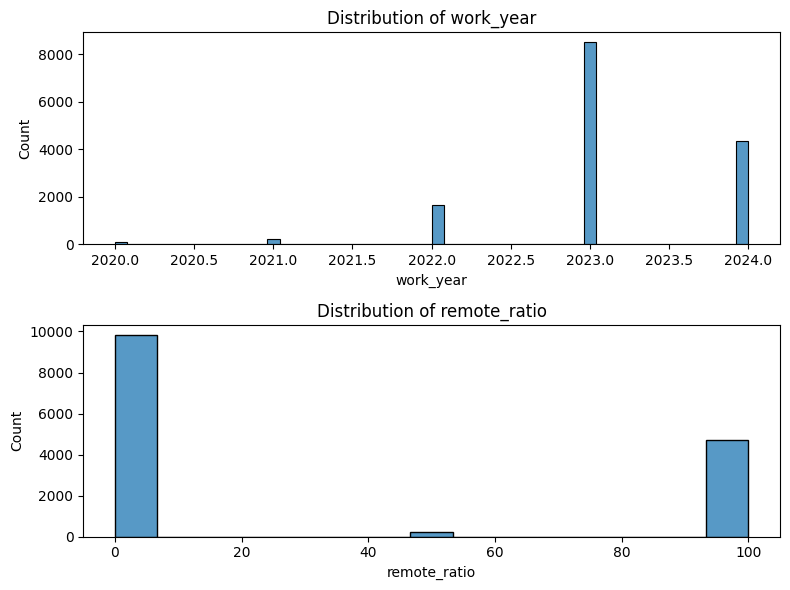

In [11]:
# Create histograms for all numerical variables
fig, axes = plt.subplots(2, 1, figsize=(8, 6))
axes = axes.ravel()

for idx, col in enumerate(numerical):
    sns.histplot(data=df, x=col, ax=axes[idx])
    axes[idx].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

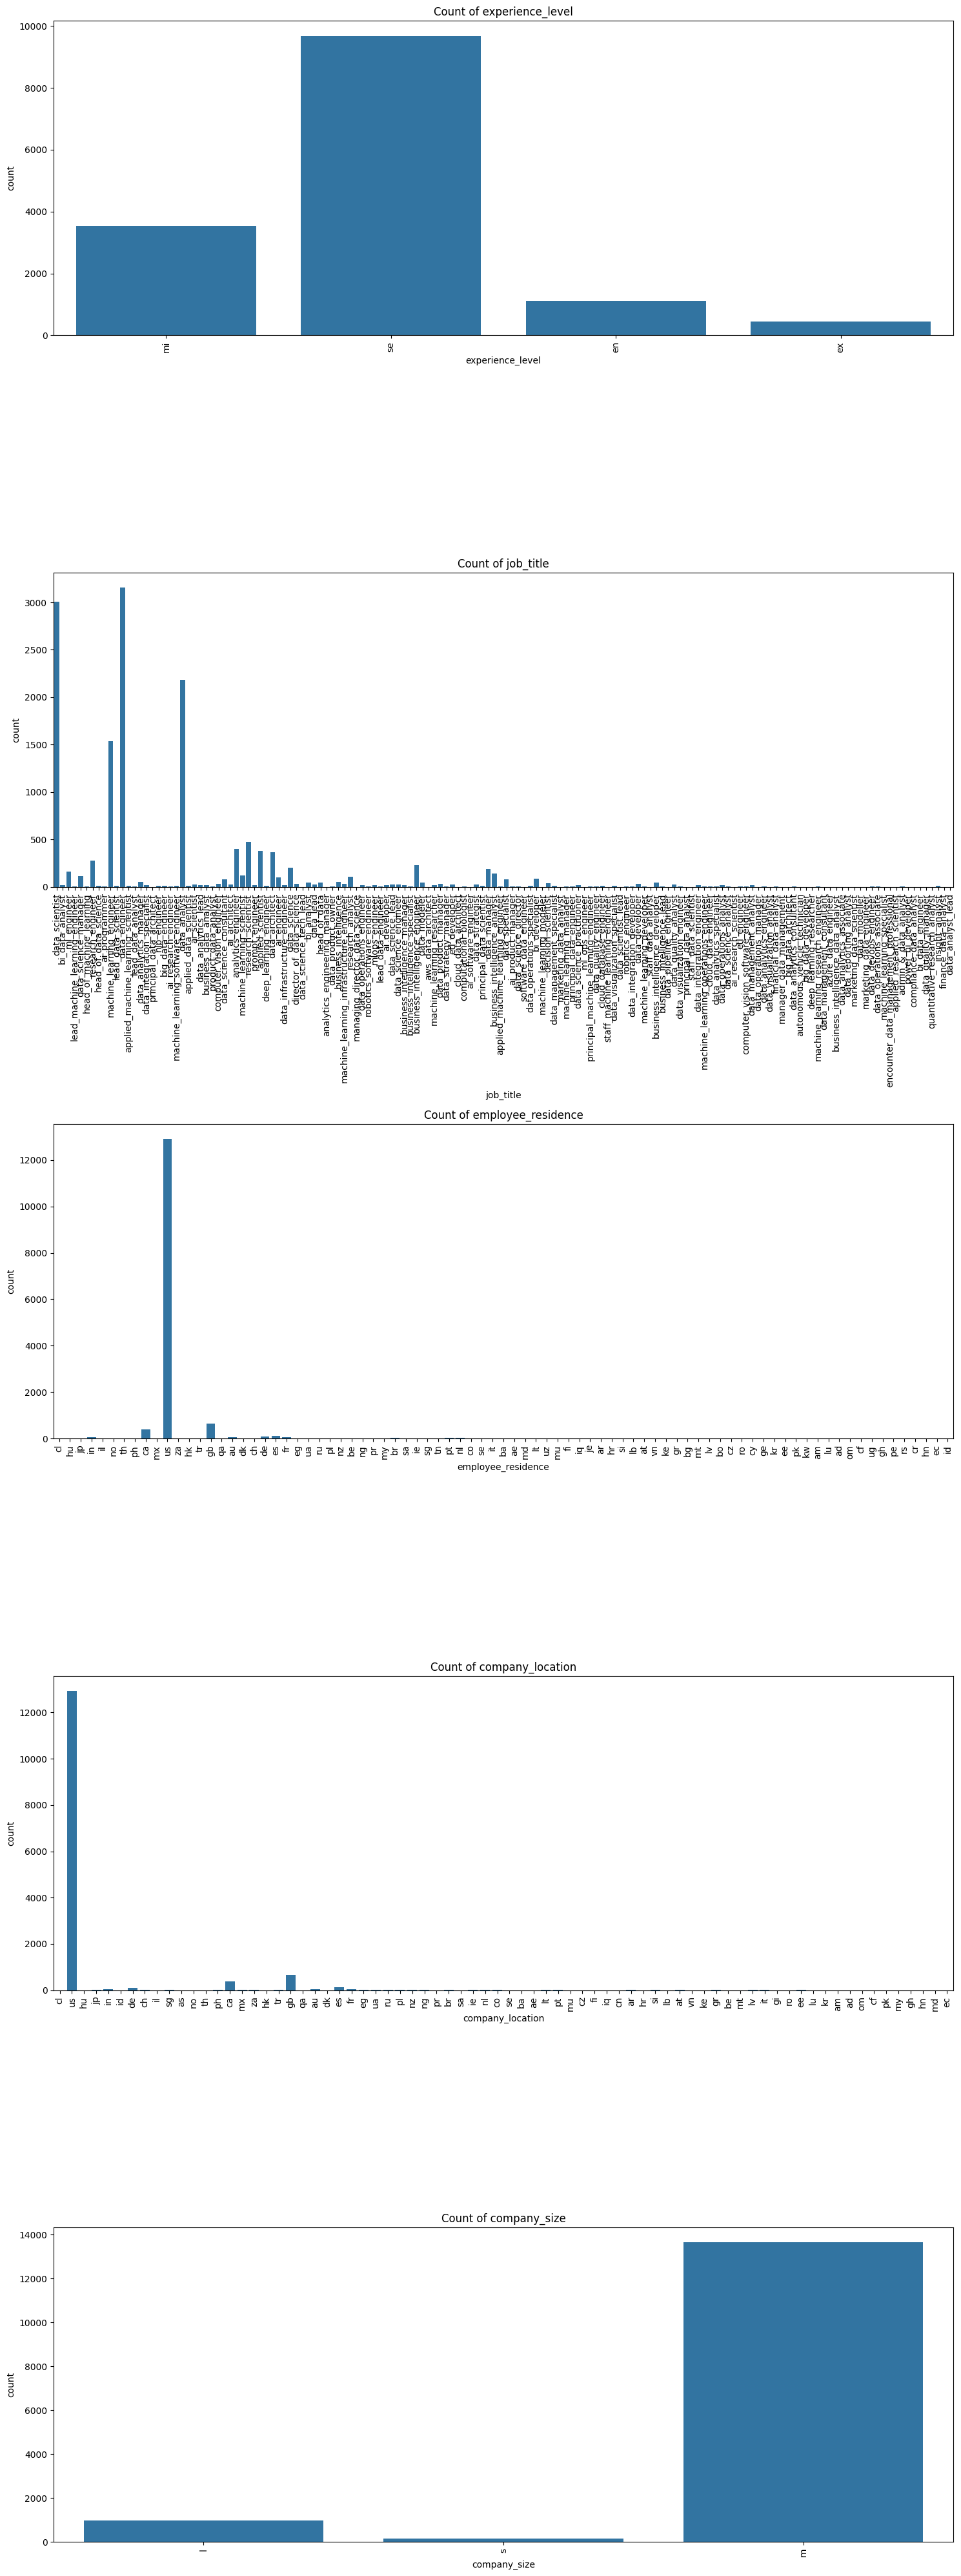

In [12]:
# Create countplots for categorical variables
fig, axes = plt.subplots(5, 1, figsize=(15, 40))
axes = axes.ravel()

for idx, col in enumerate(categorical):
    sns.countplot(data=df, x=col, ax=axes[idx])
    axes[idx].set_title(f'Count of {col}')
    axes[idx].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

<Axes: xlabel='salary_in_usd', ylabel='Count'>

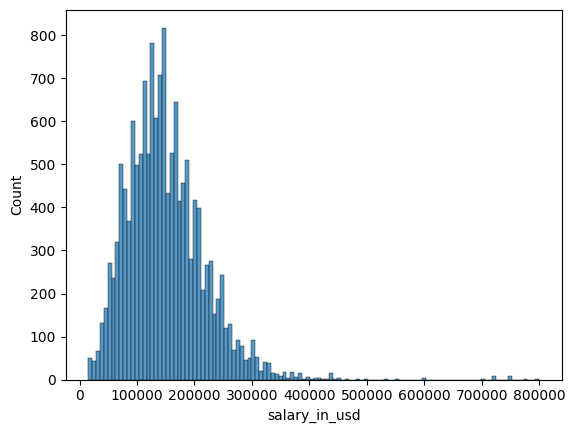

In [13]:
# Distribution of the target variable salary_in_usd
sns.histplot(df.salary_in_usd)

<Axes: xlabel='salary_in_usd', ylabel='Count'>

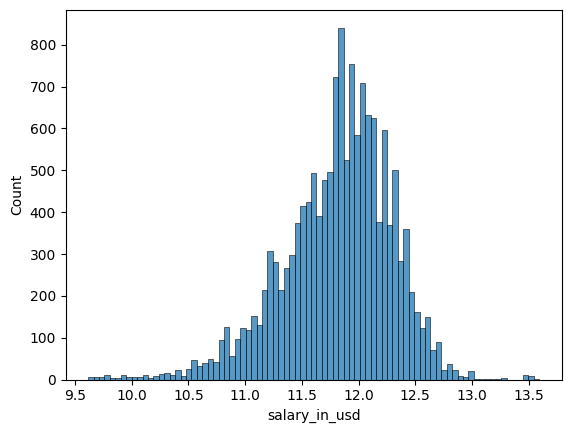

In [14]:
sns.histplot(np.log1p(df.salary_in_usd))
# It's closer to a normal distribution now

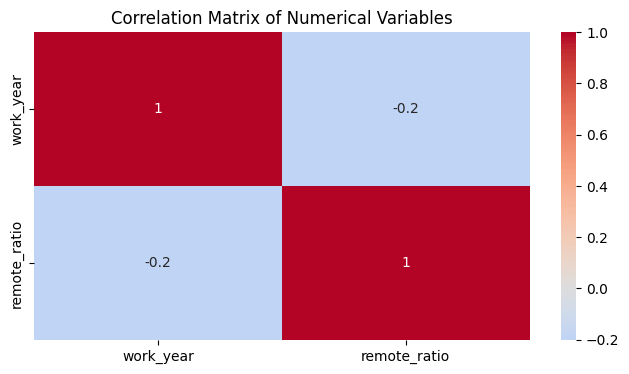

In [15]:
# Create correlation matrix heatmap
plt.figure(figsize=(8, 4))
correlation_matrix = df[numerical].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

The correlation between work_year and remote_ratio is very low, so we can keep both variables

In [16]:
# Split the data into training, validation, and test sets
seed = 42
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=seed)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=seed)
print(len(df_train), len(df_val), len(df_test))

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.salary_in_usd.values)
y_val = np.log1p(df_val.salary_in_usd.values)
y_test = np.log1p(df_test.salary_in_usd.values)

del df_train['salary_in_usd']
del df_val['salary_in_usd']
del df_test['salary_in_usd']

8862 2955 2955


In [17]:
# Prepare the data
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')
test_dict = df_test.to_dict(orient='records')

X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)
X_test = dv.transform(test_dict)

In [18]:
def train_regressor(model, X_train, y_train, X_val, y_val, param_grids={}):
    grid_search = GridSearchCV(model, param_grids, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    print(f'Best Parameters: {grid_search.best_params_}')
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'R-squared: {r2}')

    return best_model

### Linear Regression

In [19]:
linear_regressor = LinearRegression()
best_linear_regressor = train_regressor(linear_regressor, X_train, y_train, X_val, y_val)

Best Parameters: {}
Mean Squared Error (MSE): 1613313031996169.0
Root Mean Squared Error (RMSE): 40166068.16700097
Mean Absolute Error (MAE): 2240077.132962763
R-squared: -6988948048678992.0


### Ridge Regression
Error values of Linear Regression are too big, indicating that the model overfits. Therefore, we'll use Ridge Regression which uses L2 regularization.

In [20]:
ridge_regressor = Ridge()
param_grids = {
    'alpha': [0.1, 1.0, 10.0, 100.0]
}
best_ridge_regressor = train_regressor(ridge_regressor, X_train, y_train, X_val, y_val, param_grids)

Best Parameters: {'alpha': 1.0}
Mean Squared Error (MSE): 0.12111035483485162
Root Mean Squared Error (RMSE): 0.34800913039006837
Mean Absolute Error (MAE): 0.27431781439696534
R-squared: 0.47534423803013903


### Decision Tree Regression

In [21]:
decision_tree_regressor = DecisionTreeRegressor()
param_grids = {
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 10, 20]
}
best_decision_tree_regressor = train_regressor(decision_tree_regressor, X_train, y_train, X_val, y_val, param_grids)

Best Parameters: {'max_depth': 30, 'min_samples_split': 20}
Mean Squared Error (MSE): 0.1254345569508577
Root Mean Squared Error (RMSE): 0.35416741373375626
Mean Absolute Error (MAE): 0.27723830819218637
R-squared: 0.45661159077484426


### Random Forest Regression

In [22]:
random_forest_regressor = RandomForestRegressor()
param_grids = {
        'n_estimators': [10, 50, 100],
        'max_depth': [None, 10, 20, 30, 40],
        'min_samples_split': [2, 10, 20]
    }
best_random_forest_regressor = train_regressor(random_forest_regressor, X_train, y_train, X_val, y_val, param_grids)

Best Parameters: {'max_depth': 40, 'min_samples_split': 20, 'n_estimators': 50}
Mean Squared Error (MSE): 0.1198561558343519
Root Mean Squared Error (RMSE): 0.3462024780881152
Mean Absolute Error (MAE): 0.27124060806095684
R-squared: 0.4807774871785402


### Best Model
Based on the error values above and the R2 scores whose best possible score is 1.0, the best model is obtained with the Random Forest Regression. Hence, we'll use it for testing. 

### Testing

In [23]:
y_pred = best_random_forest_regressor.predict(X_test) 

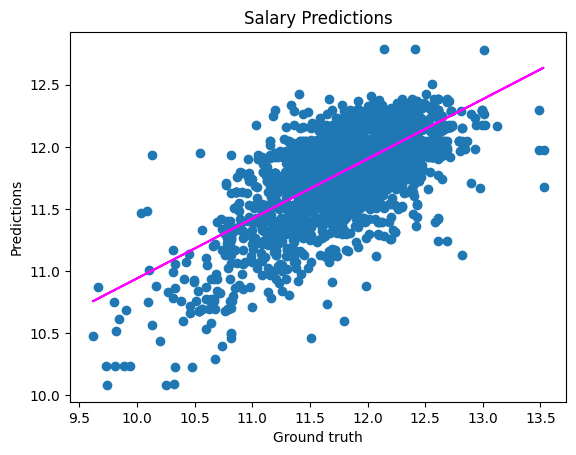

In [24]:
plt.scatter(y_test, y_pred)
plt.xlabel('Ground truth')
plt.ylabel('Predictions')
plt.title('Salary Predictions')
# overlay the regression line
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

### Saving the Model

In [25]:
model_name = 'model.bin'
with open(model_name, 'wb') as f_out:
  pickle.dump((dv, best_random_forest_regressor), f_out)

print(f'Model is saved to {model_name}')

Model is saved to model.bin
